In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
uH = 1e-6
mH = 1e-3
pF = 1e-12
nF = 1e-9
uF = 1e-6
MHz = 1e6
kHz = 1e3

In [3]:
class OnePort():
    def z(self, f): return 1 / self.y(f)
    def y(self, f): return 1 / self.z(f)

class Component(OnePort):
    def __init__(self):
        self.val = None
        
class Res(Component):
    def __init__(self, ohms):
        self.val = ohms
    def z(self, f):
        return self.val
    
class Coil(Component):
    def __init__(self, henries):
        self.val = henries
    def z(self, f):
        return 2 * np.pi * f * self.val * 1j
    
class Cap(Component):
    def __init__(self, farads):
        self.val = farads
    def y(self, f):
        return 2 * np.pi * f * self.val * 1j

class Series(OnePort):
    def __init__(self, *elems):
        self.elems = elems
    def z(self, f):
        return sum([port.z(f) for port in self.elems])
        
class Parallel(OnePort):
    def __init__(self, *elems):
        self.elems = elems
    def y(self, f):
        return sum([port.y(f) for port in self.elems])

In [4]:
# This be the impedance, purely reactive.
Cap(0.1 * uF).z(10 * MHz)

-0.15915494309189535j

In [5]:
# And this be the admittance, purely susceptant.
Cap(0.1 * uF).y(10 * MHz)

6.283185307179586j

In [6]:
C14 = C16 = Cap(180 * pF)
L7 = L9 = Coil(1 * uH)

C15 = Cap(680 * pF)
L8 = Coil(0.27 * uH)

def fr(L, C):
    return 1 / (2 * np.pi * np.sqrt(L.val * C.val))

f1 = fr(L7, C14)
f2 = fr(L8, C15)
f3 = fr(L9, C16)

for f in [f1, f2, f3]:
    print(f'{f / kHz :,.0f} kHz')

print(f'{L7.z(f1) :,.2f} ohms')
print(f'{L8.z(f2) :,.2f} ohms')
print(f'{L9.z(f3) :,.2f} ohms')

11,863 kHz
11,746 kHz
11,863 kHz
0.00+74.54j ohms
0.00+19.93j ohms
0.00+74.54j ohms


In [7]:
R_out = Res(50)

bpf = Series(
            C14,
            L7,
            Parallel(
                C15,
                L8,
                Series(
                    C16,
                    L9,
                    R_out
                )
            )
)

In [8]:
def zplots(ckt, f_start=1*MHz, f_end=30*MHz, f_step=1*kHz):
    f = np.arange(f_start, f_end, f_step)
    z = ckt.z(f)
    
    fig, mag = plt.subplots()
    mag.semilogy(f, abs(z))
    mag.set_xlabel('Frequency')
    mag.set_ylabel('Z Magnitude')
    mag.grid(True)
    
    fig, phase = plt.subplots()
    phase.plot(f, np.angle(z, deg=True))
    phase.set_xlabel('Frequency')
    phase.set_ylabel('Z Degrees')
    phase.grid(True)
    
    fig, res = plt.subplots()
    res.plot(f, np.real(z))
    res.set_xlabel('Frequency')
    res.set_ylabel('Z Real')
    res.grid(True)
  

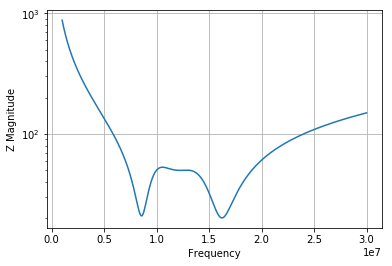

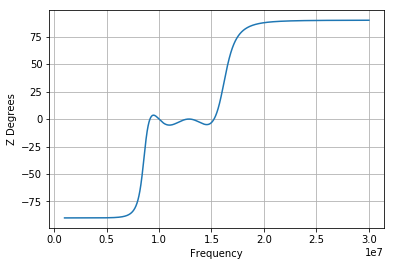

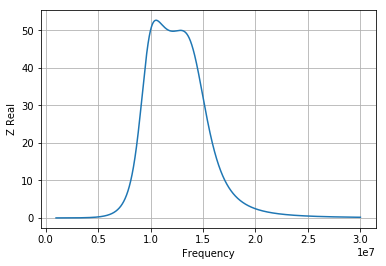

In [9]:
zplots(bpf)

In [10]:
def capacitor(freq, ohms):
    "Capacitor that has ohms reactance at freq"
    return Cap(1 / (2 * np.pi * freq * ohms))

def inductor(freq, ohms):
    "Inductor that has ohms reactance at afreq"
    return Coil(ohms / (2 * np.pi * freq))


In [11]:
R_out = Res(50)

C_12_75 = capacitor(12 * MHz, ohms=75)
L_12_75 = inductor(12 * MHz, ohms=75)

C_12_20 = capacitor(12 * MHz, ohms=20)
L_12_20 = inductor(12 * MHz, ohms=20)

bpf2 = Series(
            C_12_75,
            L_12_75,
            Parallel(
                C_12_20,
                L_12_20,
                Series(
                    C_12_75,
                    L_12_75,
                    R_out
                )
            )
)

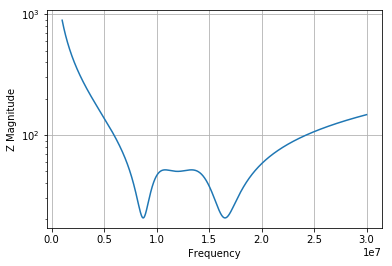

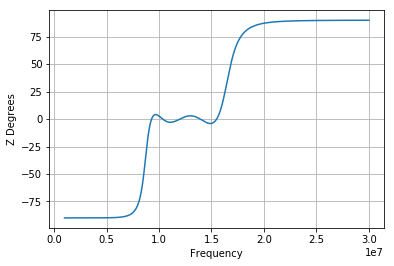

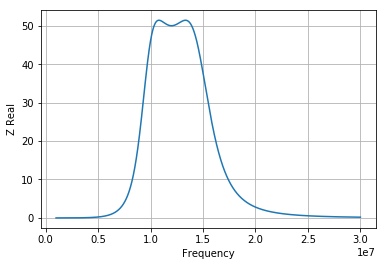

In [12]:
zplots(bpf2)

In [13]:
print(C_12_75.val / pF, "pF")
print(L_12_75.val / uH, "uH")
print("")
print(C_12_20.val / pF, "pF")
print(L_12_20.val / uH, "uH")

176.83882565766146 pF
0.994718394324346 uH

663.1455962162306 pF
0.26525823848649227 uH


In [19]:
# Frequency response plot of a filter ckt fed with a signal of
# source impedance Rs. Rl identifies the load termination of the filter,
# which is represented inside the filter itself above.  We really need
# two-port networks to do this cleanly.
def fplot(ckt, Rs, Rl, f_start=1*MHz, f_end=30*MHz, f_step=1*kHz):
    f = np.arange(f_start, f_end, f_step)
    z = ckt.z(f)
    
    v = abs(z.real / (Rs + z))
    y = 20 * np.log10(v) - 20 * np.log10(abs(Rl/ (Rl + Rs)))
    
    fig, ax = plt.subplots()
    ax.plot(f / MHz, y)
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Loss (dB)')
    ax.grid(True)

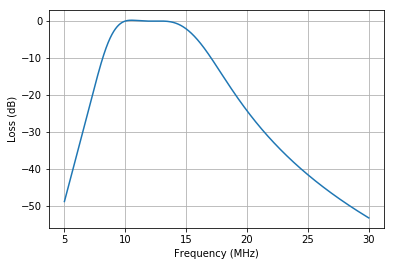

In [15]:
fplot(bpf, Rs=50, Rl=50, f_start=5*MHz)

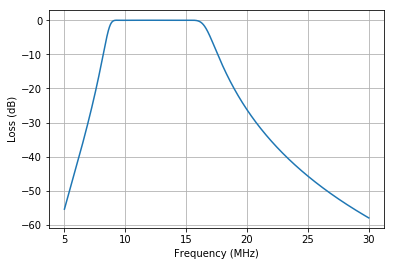

In [16]:
fplot(bpf2, Rs=0, Rl=50, f_start=5*MHz)

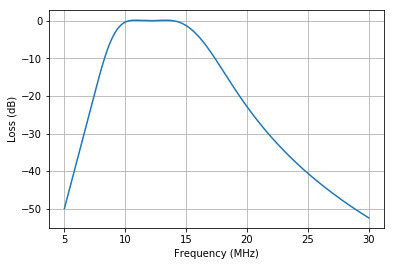

In [17]:
fplot(bpf2, Rs=50, Rl=50, f_start=5*MHz)

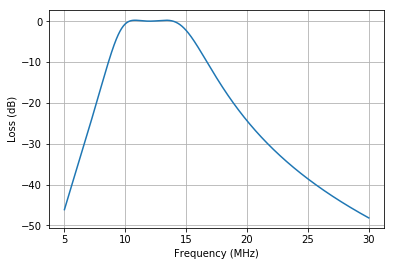

In [18]:
fplot(bpf2, Rs=600, Rl=50, f_start=5*MHz)